# Add season to our training data set

**Author:** Eli Holmes (NOAA)

## Goal add a sinusoidal season term to our model

We want an xarray Dataset with our predictors and response variables. 

- time, lat, lon
- sst, so
- ocean_mask
- sin, cos
  
## Load the libraries that we need

In [3]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

## Load data

We will start with the data set created in Part I.

In [4]:
# read in the Zarr file; a 3D (time, lat, lon) cube for a bunch of variables in the Indian Ocean
dataset = xr.open_zarr("~/shared-readwrite/cnn/part1.zarr")

In [5]:
dataset

<xarray.Dataset> Size: 104MB
Dimensions:     (lat: 149, lon: 181, time: 321)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(50, 60), meta=np.ndarray>
    so          (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
    sst         (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
    y           (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Add season as a sinusoidal


In [6]:
import numpy as np
import dask.array as da
import pandas as pd
import xarray as xr

def add_seasonal_time_features(dataset):
    """
    Adds sin_time and cos_time features to an xarray Dataset.
    These represent the seasonal cycle (day of year) and match the chunking of an existing variable.
    """
    # Convert time coordinate to pandas datetime
    time = pd.to_datetime(dataset['time'].values)

    # Day-of-year in radians
    day_of_year = time.dayofyear.to_numpy()
    day_rad = 2 * np.pi * (day_of_year / 365.25)

    # Compute sin and cos
    # Since day_sin is constant across space, 
    # you first reshape it to (time, 1, 1). 
    # Then you can broadcast it across all lat/lon values:
    day_sin = np.sin(day_rad).astype(np.float32)[:, np.newaxis, np.newaxis]
    day_cos = np.cos(day_rad).astype(np.float32)[:, np.newaxis, np.newaxis]

    # Wrap in Dask arrays
    sin_time = da.from_array(day_sin)
    cos_time = da.from_array(day_cos)

    # Broadcast across the lat/lon space
    shape = dataset['sst'].shape
    sin_time = da.broadcast_to(sin_time, shape)
    cos_time = da.broadcast_to(cos_time, shape)

    # Match chunking of a reference variable (e.g., sst)
    sin_time = sin_time.rechunk(dataset['sst'].data.chunks)
    cos_time = cos_time.rechunk(dataset['sst'].data.chunks)

    # Add to dataset
    return dataset.assign(
        sin_time=(("time", "lat", "lon"), sin_time),
        cos_time=(("time", "lat", "lon"), cos_time)
    )


In [7]:
# Add season
dataset = add_seasonal_time_features(dataset)
dataset

<xarray.Dataset> Size: 173MB
Dimensions:     (lat: 149, lon: 181, time: 321)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(50, 60), meta=np.ndarray>
    so          (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
    sst         (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
    y           (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
    cos_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 50, 60), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

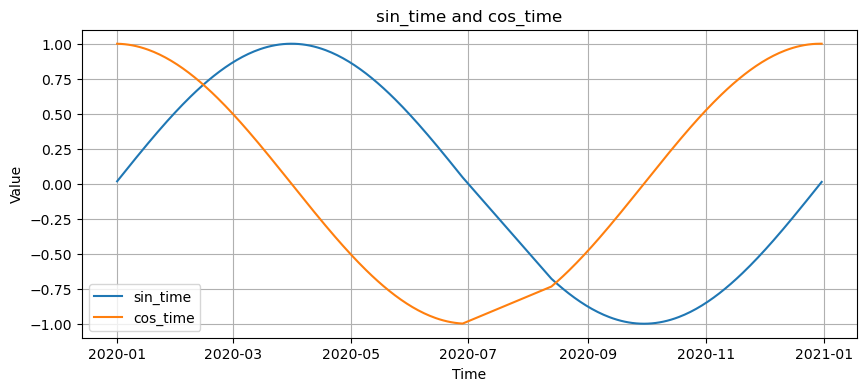

In [8]:
# Let's check that sin and cos look good
import matplotlib.pyplot as plt

# Pick a grid point
ilat, ilon = 50, 90

# Extract time series
sin_series = dataset['sin_time'][:, ilat, ilon].values
cos_series = dataset['cos_time'][:, ilat, ilon].values
time = dataset['time'].values

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time, sin_series, label='sin_time')
plt.plot(time, cos_series, label='cos_time')
plt.legend()
plt.title(f'sin_time and cos_time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Re-chunk to optimize for CNN

Square chunks are better and we will need 1 day chunks when we are doing lazy loading.

In [9]:
# Re-chunk for efficient training
ds = xr.Dataset({
    var: dataset[var].chunk({
        dim: chunk for dim, chunk in {'time': 100, 'lat': 64, 'lon': 64}.items()
        if dim in dataset[var].dims
    })
    for var in dataset.data_vars
})
# Clear meta data otherwise, will get error on trying to write the Zarr
for var in ds.variables:
    ds[var].encoding.pop("chunks", None)
ds

<xarray.Dataset> Size: 173MB
Dimensions:     (lat: 149, lon: 181, time: 321)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    so          (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    sst         (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    y           (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    cos_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>

## Make ocean_mask float32 since TensorFlow is going to expect that

In [10]:
ds["ocean_mask"] = ds["ocean_mask"].astype("float32")

## Save as a Zarr file


In [11]:
#data_xr.to_zarr("part2.zarr", mode="w")
#ds.to_zarr("~/shared-readwrite/cnn/part2.zarr", mode="w")

In [12]:
# test
test = xr.open_zarr("~/shared-readwrite/cnn/part2.zarr")
test

<xarray.Dataset> Size: 173MB
Dimensions:     (time: 321, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    cos_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    ocean_mask  (lat, lon) float32 108kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    so          (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    sst         (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    y           (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>

## Summary

Now we are ready to fit our CNN model.